# Black-Scholes option pricing with Monte Carlo on Python


In [54]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()

**The BSM equation:**

$$
\frac{\partial V}{\partial t}+\frac{1}{2} \sigma^{2} S^{2} \frac{\partial^{2} V}{\partial S^{2}}+r S \frac{\partial V}{\partial S}-r V=0
$$

This is the partial differential equation, which governs the price of an option.

**Analytical solution of BSM equation:**

The value of a call option $c\left(S_{0}, t\right)$ can be written in the simplified was a follows


$$
c\left(S_{0}, t\right)=S_{0} N\left(d_{1}\right)-K e^{r(T-t)} N\left(d_{2}\right)
$$

with,

$$
d_{1}=\frac{\log \left(S_{0} / K\right)+\left(r+\frac{1}{2} \sigma^{2}\right)(T-t)}{\sigma \sqrt{T-t}}
$$

$$
d_{2}=\frac{\log \left(S_{0} / K\right)+\left(r-\frac{1}{2} \sigma^{2}\right)(T-t)}{\sigma \sqrt{T-t}}=d_{1}-\sigma \sqrt{T-t}
$$

and $N$ is the CDF of standard normal distribution.

# Exact Solution

In [55]:
# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability    
def d21(d1, T, sigma):
    return d1 - sigma * np.sqrt(T)

In [56]:
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.
    
    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate 
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'
    
    Returns: a numpy.float_ representing the option value
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        
        raise ValueError("Option type is either 'call' or 'put'.")

# Monte Carlo Method

We use the following alorithm to price an option,
1. Simulate the stock price under the risk neutral measure for the the desired time.
2. Calculate the payoff
3. Repeat step 1 and 2 for many times
4. Calculate the average payoff
5. Take the present value of the average payoff
To perform the first step we assume the following time evolution for the stock price

$$
d S_{t}=r S_{t} d t+\sigma S_{t} d Z_{t}
$$

Which can be descretized using Euler method as follows

$$
S_{t}=S_{t-\Delta t} \exp \left(\left(r-\frac{1}{2} \sigma^{2}\right) \Delta t+\sigma \sqrt{\Delta t} z_{t}\right)
$$

$$
\log S_{t}=\log S_{t-\Delta t}+\left(r-\frac{1}{2} \sigma^{2}\right) \Delta t+\sigma \sqrt{\Delta t} z_{t}
$$


The payoff depends upon the type of option in hand. Given the payoff as a function of stock price, the price of an option is calculated using

$$
\text { option price }=e^{-r(T-t)} \tilde{E}[\text { Payoff }(S)]
$$

Below we show the price of an Europian call option.

In [57]:
S0 = 100.; K = 105.; T = 1.0; r = 0.05; sigma = 0.2
M = 50; dt = T / M; I = 250000

def simulate_stock_price():
    # Simulating I paths with M time step
    S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt 
                        + sigma * np.sqrt(dt)* np.random.standard_normal((M + 1, I)), axis=0))
    return S

S = simulate_stock_price()

In [58]:
S[0] = S0
# Calculating the Monte Carlo estimator
C0 = math.exp(-r * T) * sum(np.maximum(S[-1] - K, 0)) / I
print('Monte Carlo Value is: ', C0)
exact_C0 = black_scholes(S0, K, T, r, sigma, "call")
print('Exact Value is:', exact_C0)

Monte Carlo Value is:  8.17660694761175
Exact Value is: 8.021352235143176


<IPython.core.display.Javascript object>


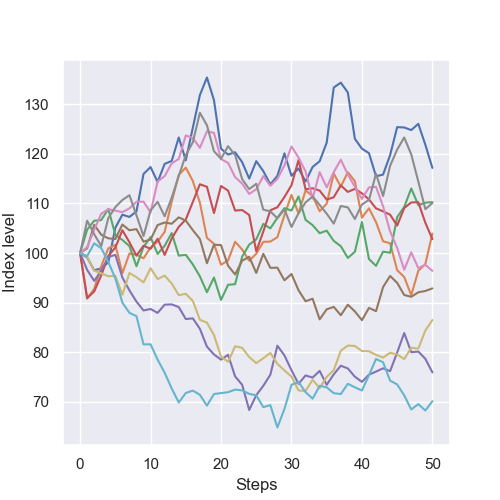

In [59]:
fig, ax1 = plt.subplots()
ax1 = plt.plot(S[:, :10])
plt.xlabel('Steps')
plt.ylabel('Index level')
plt.show(fig)

<IPython.core.display.Javascript object>


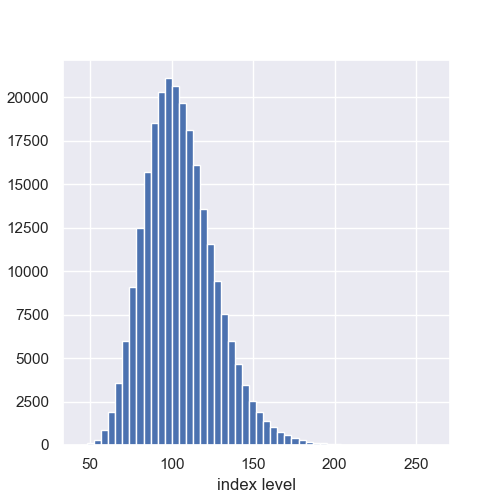

In [61]:
fig, ax = plt.subplots()

ax = plt.rcParams["figure.figsize"] = (15,8)
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.show(fig)